# Evaluate a UQ model

In [ ]:
print("apple")

In [16]:
import torch
import numpy as np

# dataset
from twaidata.torchdatasets.in_ram_ds import MRISegmentation2DDataset, MRISegmentation3DDataset
from torch.utils.data import DataLoader, random_split, ConcatDataset

# model
from trustworthai.models.uq_models.drop_UNet import UNet

# augmentation and pretrain processing
from trustworthai.utils.augmentation.standard_transforms import RandomFlip, GaussianBlur, GaussianNoise, \
                                                            RandomResizeCrop, RandomAffine, \
                                                            NormalizeImg, PairedCompose, LabelSelect, \
                                                            PairedCentreCrop, CropZDim
# loss function
from trustworthai.utils.losses_and_metrics.tversky_loss import TverskyLoss
from trustworthai.utils.losses_and_metrics.misc_metrics import IOU
from trustworthai.utils.losses_and_metrics.dice import dice, DiceMetric
from trustworthai.utils.losses_and_metrics.dice_losses import DiceLoss, GeneralizedDiceLoss
from trustworthai.utils.losses_and_metrics.power_jaccard_loss import PowerJaccardLoss
from torch.nn import BCELoss, MSELoss

# pl
from trustworthai.utils.uq.sampling.sampling_pl_wrapper import UQSamplingPredictorLitModelWrapper
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
import pytorch_lightning as pl

# misc
import os
import torch
import matplotlib.pyplot as plt
import torch
from torchinfo import summary

In [3]:
seed = 3407
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [4]:
root_dir = "/disk/scratch/s2208943/ipdis/preprep/out_data/collated/"
wmh_dir = root_dir + "WMH_challenge_dataset/"
ed_dir = root_dir + "EdData/"

In [5]:
# domains = [
#             wmh_dir + d for d in ["Singapore", "Utrecht", "GE3T"]
#           ]
# domains = [
#             wmh_dir + d for d in ["Singapore", "Utrecht", "GE3T"]
#           ] + [
#             ed_dir + d for d in ["domainA", "domainB", "domainC", "domainD"]
#           ]

domains = [
            ed_dir + d for d in ["domainA", "domainB", "domainC", "domainD"]
          ]

In [6]:
# function to do train validate test split
test_proportion = 0.1
validation_proportion = 0.2

def train_val_test_split(dataset, val_prop, test_prop, seed):
    # I think the sklearn version might be prefereable for determinism and things
    # but that involves fiddling with the dataset implementation I think....
    size = len(dataset)
    test_size = int(test_prop*size) 
    val_size = int(val_prop*size)
    train_size = size - val_size - test_size
    train, val, test = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(seed))
    return train, val, test

In [7]:
is3D = False

In [8]:
# augmentation definintion
def get_transforms(is3D):
    transforms = [
        LabelSelect(label_id=1),
        RandomFlip(p=0.5, orientation="horizontal"),
        # GaussianBlur(p=0.5, kernel_size=7, sigma=(.1, 1.5)),
        # GaussianNoise(p=0.2, mean=0, sigma=0.2),
        # RandomAffine(p=0.2, shear=(.1,3.)),
        # RandomAffine(p=0.2, degrees=5),
        # RandomResizeCrop(p=1., scale=(0.6, 1.), ratio=(3./4., 4./3.))
    ]
    if not is3D:
        return PairedCompose(transforms)
    else:
        transforms.append(CropZDim(size=32, minimum=0, maximum=-1))
        return PairedCompose(transforms)

In [9]:
if is3D:
    transforms = CropZDim(size=32, minimum=0, maximum=-1)
    datasets_domains = [MRISegmentation3DDataset(root_dir, domain, transforms=get_transforms(is3D)) for domain in domains]
else:
    datasets_domains = [MRISegmentation2DDataset(root_dir, domain, transforms=get_transforms(is3D)) for domain in domains]

# split into train, val test datasets
datasets = [train_val_test_split(dataset, validation_proportion, test_proportion, seed) for dataset in datasets_domains]

# concat the train val test datsets
train_dataset = ConcatDataset([ds[0] for ds in datasets])
val_dataset = ConcatDataset([ds[1] for ds in datasets])
test_dataset = ConcatDataset([ds[2] for ds in datasets])

In [10]:
len(train_dataset), len(val_dataset), len(test_dataset)

(8743, 2497, 1248)

In [11]:
# define dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size = 16, shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

### setup model and do some evaluation

In [12]:
#from trustworthai.utils.uq.sampling.sampling_pl_wrapper import UQSamplingPredictorLitModelWrapper
from trustworthai.utils.uq.uncertainty_maps.gen_map import samples_entropy_map, samples_variance_map
from trustworthai.utils.uq.sampling.uq_prediction_sampler import DeterministicModelUQSampler

In [97]:
in_channels = 3
out_channels = 1
# TODO: put in the path to the assets on your machine here
checkpoint_dir = "/home/s2208943/ipdis/results/dropout_and_norm_initial_tests/UNet2D_dropout_bernoulli_0.4_bn_epochs_400/"
checkpoint = checkpoint_dir + "epoch=61-step=33914.ckpt"

p=0.4
mdim=True
args = {
    "dropout_type":"bernoulli",
    "dropconnect_type":None,
    "p":p,
    "mdim":False,
    "norm_type":"bn",
    "gn_groups":4
}

model = UNet(in_channels,
             out_channels,
             kernel_size=3,
             init_features=32,
             softmax=False,
             dropout_type=args["dropout_type"],
             dropout_p=args["p"],
             gaussout_mean=1, 
             dropconnect_type=args["dropconnect_type"],
             dropconnect_p=args["p"],
             gaussconnect_mean=1,
             norm_type=args["norm_type"],
             use_multidim_dropout=args["mdim"],  
             use_multidim_dropconnect=args["mdim"], 
             groups=None,
             gn_groups=args["gn_groups"], 
            )
    
loss = GeneralizedDiceLoss(normalization='sigmoid')

In [98]:
sampler = DeterministicModelUQSampler(N=20, is_uq_model=True)

In [99]:
model = UQSamplingPredictorLitModelWrapper.load_from_checkpoint(checkpoint, model=model, loss=loss, sampler=sampler, is_uq_model=True)


In [100]:
# model = StandardLitModelWrapper.load_from_checkpoint(checkpoint, model=model, loss=loss, 
#                                 optimizer_params=None,
#                                 lr_scheduler_params=None,
#                                 is_uq_model=True
#                                )

In [101]:
accelerator="gpu"
devices=1
precision = 16

trainer = pl.Trainer(
    accelerator=accelerator,
    devices=devices,
    precision=precision,
)


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### evaluate

In [102]:
trainer.validate(model, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.3632868826389313
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.3632868826389313}]

In [103]:
trainer.test(model, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.35403913259506226
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.35403913259506226}]

In [104]:
# Try computing some uncertainty
results = trainer.predict(model, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [105]:
# we do the [:-1] on results to drop the last batch which is of length 1
samples = torch.stack([r[0] for r in results[:-1]], dim=1)
mle_ests = torch.stack([r[1] for r in results[:-1]], dim=1)
xs = torch.stack([r[2] for r in results[:-1]], dim=1)
ys = torch.stack([r[3] for r in results[:-1]], dim=1)

In [106]:
b1_sample = samples[0]
b1_mle_est = mle_ests[0]
b1_xs = xs[0]
b1_ys = ys[0]

In [107]:
b1_tsample = b1_sample.type(torch.float32)

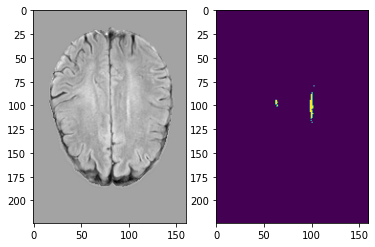

In [168]:
img = 55
plt.subplot(1,2,1)
plt.imshow(b1_xs[img][0].squeeze(), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(b1_ys[img].squeeze()); plt.show()

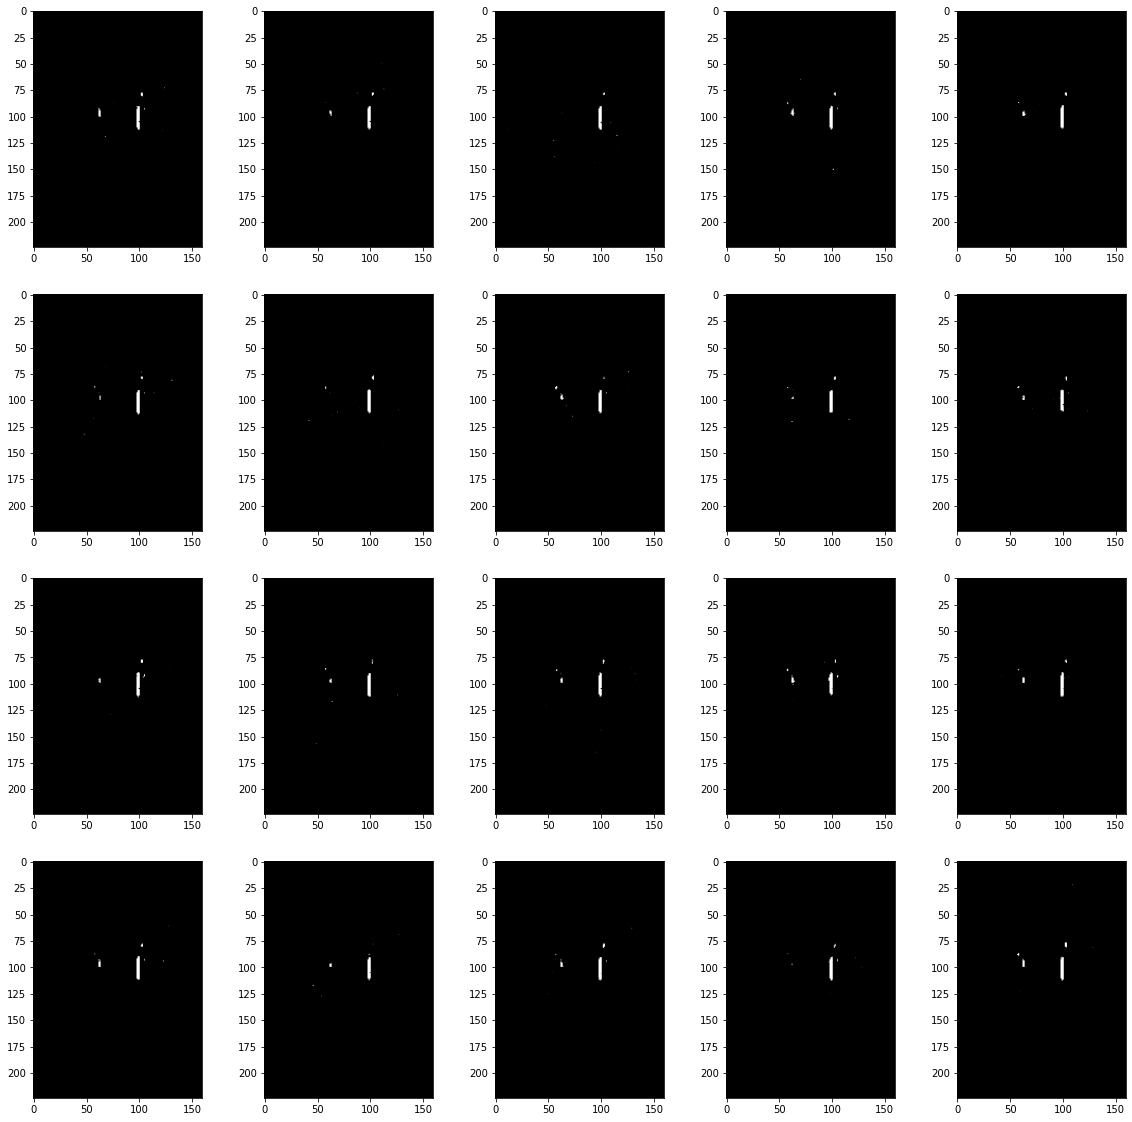

In [169]:
# see all the samples from an index in the batch
# this is messed up it should be 77, 16 not 16, 77
plt.figure(figsize=(20, 20))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(torch.sigmoid(b1_tsample[img, i]).squeeze(), cmap='gray')

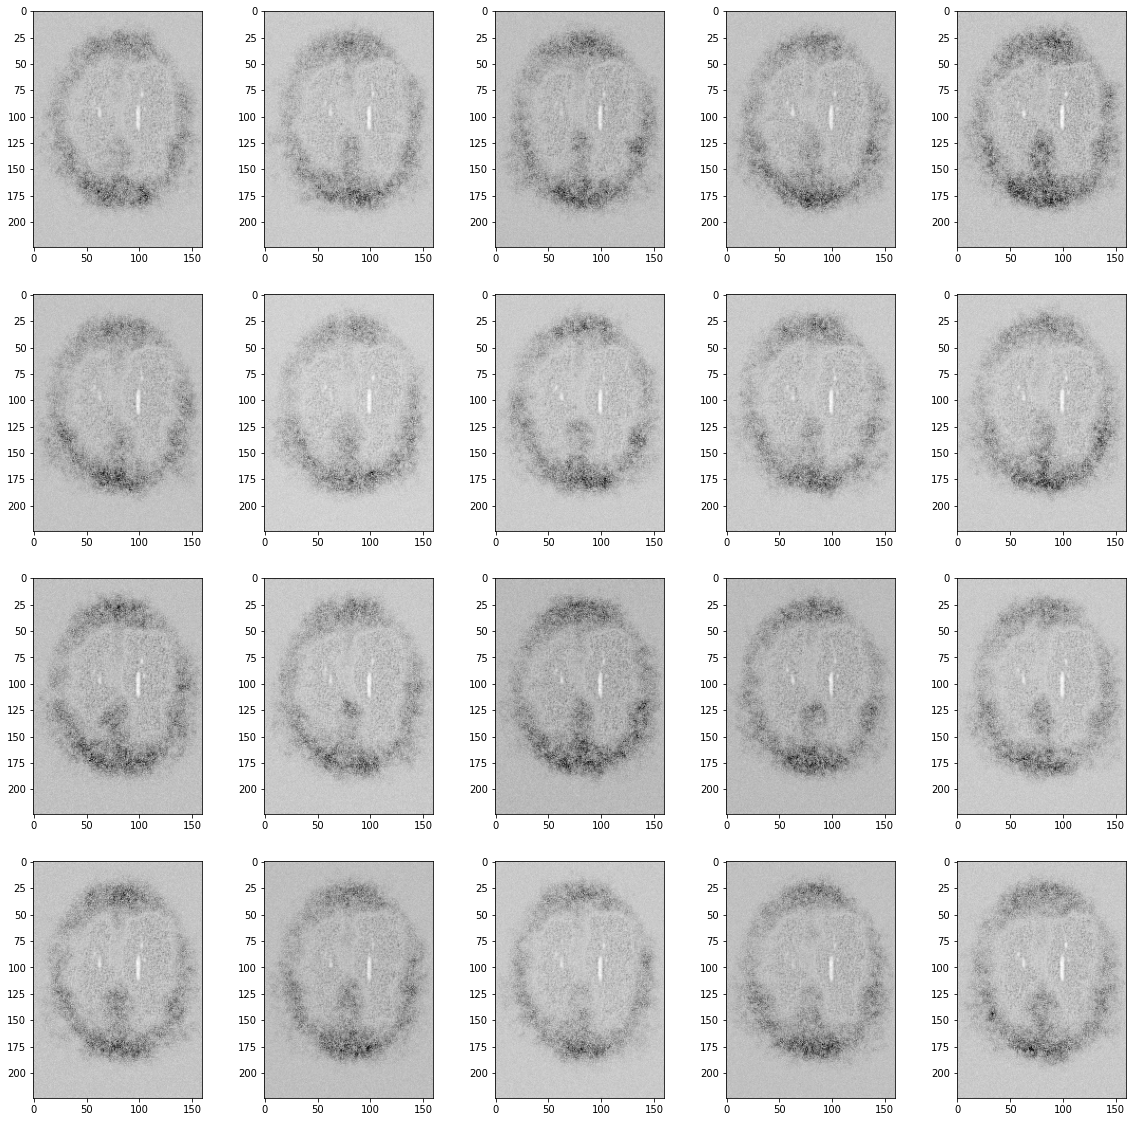

In [171]:
plt.figure(figsize=(20, 20))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow((b1_tsample[img, i]).squeeze(), cmap='gray')

In [172]:
mode = torch.mode(torch.sigmoid(b1_tsample[img]), dim=0)[0]

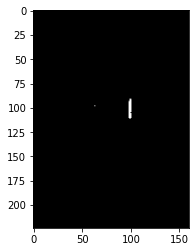

In [174]:
plt.imshow(mode.squeeze(), cmap='gray')

In [175]:
est = torch.sigmoid(b1_mle_est[img].type(torch.float32)).squeeze()
dice(est, b1_ys[img].squeeze())

tensor(1.0721)

In [176]:
# dice is clearly a bit broken...
dice(mode, b1_ys[img].squeeze())

tensor(1.1919)

In [177]:
e = samples_entropy_map(torch.sigmoid(b1_tsample[img].type(torch.float32)),
                    p_from_mode=True,
                    threshold_preds=False,
                    preds_threshold=0.9,
                    apply_norm=False,
                    norm_func='sigmoid',
                    apply_binning=True,
                    binning_dp = 1,
                    supress_warning=False,
                    print_uniques=True
                   )

warning, binning should only be applied where output is a probability
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


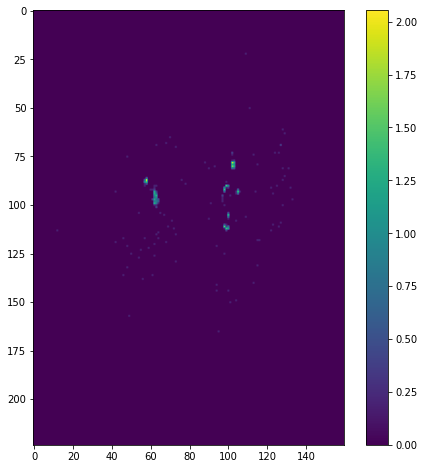

In [178]:
plt.figure(figsize=(8,8))
plt.imshow(e.squeeze())
plt.colorbar()
plt.show()


In [179]:
e2 = samples_entropy_map(torch.sigmoid(b1_tsample[img].type(torch.float32)),
                    p_from_mode=True,
                    threshold_preds=True,
                    preds_threshold=0.5,
                    apply_norm=False,
                    norm_func='sigmoid',
                    apply_binning=False,
                    binning_dp = 1,
                    supress_warning=False,
                    print_uniques=True
                   )

warning, thresholding only valid for binary class problem
[False  True]


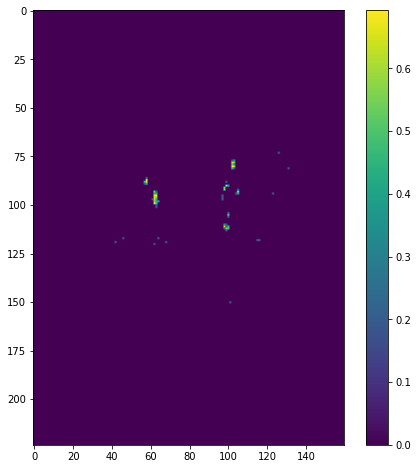

In [180]:
plt.figure(figsize=(8,8))
plt.imshow(e2.squeeze())
plt.colorbar()
plt.show()


In [1]:
import numpy as np

In [2]:
x = np.array([0,1,2,3,4,5,-1,0])

In [5]:
np.ma.log(x).fill(0)

In [10]:
np.ma.log(x).filled(0)

array([0.        , 0.        , 0.69314718, 1.09861229, 1.38629436,
       1.60943791, 0.        , 0.        ])